In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
import seaborn as sns
from sys import platform
from tqdm import tqdm

from trianglechain import TriangleChain

import torch
from msi.flow_conductor.likelihood_flow import LikelihoodFlow
from msi.flow_conductor import architecture

from msfm.utils import files, observation, cross_statistics, power_spectra
from deep_lss.utils import configuration
from msi.utils import preprocessing, plotting

# load network compressions

# v14

In [3]:
msfm_conf = files.load_config("/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v14/extended.yaml")
base_dir = "/pscratch/sd/a/athomsen/v11desy3/v14/extended"
out_dir = "/pscratch/sd/a/athomsen/run_files/v14/cls"

### lensing

In [4]:
# with_lensing = True
# with_clustering = False
# params = ["Om", "s8", "w0", "Aia", "n_Aia", "bta"]

# file_label = "8mpc"
# dlss_conf = configuration.load_deep_lss_config(
#     f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/clustering/smoothing_fwhm/dlss_{file_label}.yaml"
# )

# # Cls
# n_steps_cls = 200_000

# # maps
# # young-serenity-1089 (https://wandb.ai/eth-cosmo/y3-deep-lss/runs/3g0z8qob/overview)
# # first v14 run
# model_dir = "/pscratch/sd/a/athomsen/run_files/v14/extended/lensing/mutual_info/2025-04-19_18-54-31_deepsphere_default"
# n_steps_maps = 400_000

### clustering

In [5]:
with_lensing = False
with_clustering = True
params = ["Om", "s8", "w0", "bg1", "bg2", "bg3", "bg4"]

file_label = "32mpc"
dlss_conf = configuration.load_deep_lss_config(
    f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/clustering/smoothing_fwhm/dlss_{file_label}.yaml"
)

# Cls
n_steps_cls = 400_000

# maps
# classic-frost-1096 (https://wandb.ai/eth-cosmo/y3-deep-lss/runs/fp2vxm07/overview)
# first v14 clustering probes run
model_dir = "/pscratch/sd/a/athomsen/run_files/v14/extended/clustering/mutual_info/2025-05-14_23-10-45_deepsphere_default"
n_steps_maps = 240_000

25-06-11 00:00:32 configuratio INF   Loaded the config 


### combined

In [6]:
# with_lensing = True
# with_clustering = True
# params = ["Om", "s8", "w0", "Aia", "n_Aia", "bta", "bg1", "bg2", "bg3", "bg4"]

# file_label = "8,32mpc"
# dlss_conf = configuration.load_deep_lss_config(
#     f"/global/u2/a/athomsen/y3-deep-lss/configs/v14/combined/dlss_{file_label}.yaml"
# )

# # Cls
# n_steps_cls = 300_000

# # maps
# # grateful-universe-1093 (https://wandb.ai/eth-cosmo/y3-deep-lss/runs/tun9hdvl/overview)
# # first v14 combined probes run
# model_dir = "/pscratch/sd/a/athomsen/run_files/v14/extended/combined/mutual_info/2025-04-30_02-27-42_deepsphere_default"
# n_steps_maps = 400_000

# $C_\ell$

In [7]:
# apply_log = True
# standardize = False
# pca_components = None
# cosine_decay = False
# label = f"lensing={with_lensing},clustering={with_clustering},standard={standardize},log=True,cosine={cosine_decay},steps={n_steps}"

# label = os.path.join(label, file_label)
# loss = "mutual_info"

# pred_file = os.path.join(out_dir, loss, label, "preds.h5")
# print(pred_file)

# def try_mock(f, mock):
#     try:
#         pred = f[f"mocks/pred/{mock}"][:]
#         print(f"Read {mock} predictions")
        
#         return pred
#     except:
#         print(f"There is no {mock} mock in the file")

# buzzard_preds = []
# with h5py.File(pred_file, "r") as f:
#     grid_preds = f["grid/preds/test"][:]
#     grid_cosmos = f["grid/cosmos/test"][:]
#     fidu_preds = f["fidu/preds"][:]

#     buzzard_indices = list(range(0, 16))
#     buzzard_indices.remove(1)
#     for i in buzzard_indices:
#         buzzard_preds.append(try_mock(f, f"Buzzard_{i}"))

# buzzard_preds = np.concatenate(buzzard_preds)
# print(grid_preds.shape)
# print(grid_cosmos.shape)
# print(buzzard_preds.shape)

# maps

In [8]:
# dataset
fidu_preds, grid_preds, grid_cosmos, file_dict = preprocessing.get_reshaped_network_preds(
    "",
    model_dir,
    n_steps_maps,
)

buzzard_indices = list(range(0, 16))
buzzard_indices.remove(1)
buzzard_preds = []
for i in buzzard_indices:
    buzzard_preds.append(file_dict[f"mocks/pred/Buzzard_{i}"])
buzzard_preds = np.stack(buzzard_preds, axis=0)

# output directory and file names
out_dir = os.path.join(base_dir, model_dir)

label = f"{n_steps_maps}_steps_likelihood"

print(grid_preds.shape)
print(grid_cosmos.shape)
print(buzzard_preds.shape)

25-06-11 00:00:32 input_output INF   Loading predictions from /pscratch/sd/a/athomsen/run_files/v14/extended/clustering/mutual_info/2025-05-14_23-10-45_deepsphere_default/preds_240000.h5 
25-06-11 00:00:32 input_output INF   Array shapes: 
25-06-11 00:00:33 input_output INF   fiducial/vali/pred = (40000, 14) 
25-06-11 00:00:33 input_output INF   fiducial/vali/i_example = (40000,) 
25-06-11 00:00:33 input_output INF   fiducial/vali/i_noise = (40000,) 
25-06-11 00:00:33 input_output INF   grid/pred          = (2500, 80, 14) 
25-06-11 00:00:33 input_output INF   grid/cosmo         = (2500, 80, 7) 
25-06-11 00:00:33 input_output INF   grid/i_example     = (2500, 80) 
25-06-11 00:00:33 input_output INF   grid/i_noise       = (2500, 80) 
25-06-11 00:00:33 input_output INF   grid/i_sobol       = (2500, 80) 


25-06-11 00:00:33 preprocessin INF   Shapes after concatenation and selection: 
25-06-11 00:00:33 preprocessin INF   fidu_preds  = (40000, 14) 
25-06-11 00:00:33 preprocessin INF   grid_

# normalizing flow $p(x | \theta)$

### initialization

In [9]:
# input dimensions
x_dim = grid_preds.shape[-1]
theta_dim = grid_cosmos.shape[-1]

# shared hyperparameters
context_embedding_dim = 32

embedding_net = architecture.get_context_embedding_net(
    context_dim=theta_dim,
    context_embedding_dim=context_embedding_dim,
    hidden_dim=64,
    n_blocks=3,
    dropout_probability=0.0,
    use_batch_norm=False,
)    

base_dist = architecture.get_normal_dist(
    feature_dim=x_dim,
)

transform = architecture.get_sigmoids_transform(
    feature_dim=x_dim,
    context_embedding_dim=context_embedding_dim,
    n_layers=4,
    hidden_dim=256,
    svd_kwargs={},
    sigmoids_kwargs={
        "n_sigmoids": 16,
        "num_blocks": 3,
        "dropout_probability": 0.0,
    }
)

# transform = architecture.get_lipschitz_transform(
#     feature_dim=x_dim,
#     context_embedding_dim=context_embedding_dim,
#     n_layers=5,
#     hidden_dim=256,
# )

model = LikelihoodFlow(
    params, 
    msfm_conf, 
    embedding_net=embedding_net,
    base_dist=base_dist,
    transform=transform,
    out_dir=out_dir, 
    # label=label,
    label=label + "_sigmoid",
    load_existing=True,
)

25-06-11 00:00:33 likelihood_b INF   Set up the model directory /pscratch/sd/a/athomsen/run_files/v14/extended/clustering/mutual_info/2025-05-14_23-10-45_deepsphere_default/240000_steps_likelihood_sigmoid/likelihood_flow 
25-06-11 00:00:33 likelihood_f INF   Initialized the normalizing flow 
25-06-11 00:00:33 likelihood_f INF   Running on device cuda with default float torch.float32 
25-06-11 00:00:33 likelihood_f INF   Loaded the model from /pscratch/sd/a/athomsen/run_files/v14/extended/clustering/mutual_info/2025-05-14_23-10-45_deepsphere_default/240000_steps_likelihood_sigmoid/likelihood_flow/likelihood_flow.pt 


# sample from $p(x | x_\text{obs})$

In [10]:
# x_obs
i_buzzard = 0
obs_pred = np.atleast_2d(buzzard_preds[i_buzzard])

# likelihood p(x_obs | theta) 
log_probs = model.log_likelihood(
    np.repeat(obs_pred, grid_cosmos.shape[0], axis=0),
    grid_cosmos,
)
log_probs = log_probs.cpu().numpy()

In [11]:
def sample_from_log_probs(items, log_probs, n_samples=1000, random_seed=None):
    """
    Sample from an array based on log probabilities and return normalized probabilities for alpha plotting.
    
    Args:
        items: Array-like of items to sample from
        log_probs: Array-like of log probabilities (same length as items)
        n_samples: Number of samples to draw
        random_seed: Optional seed for reproducibility
    
    Returns:
        samples: Array of sampled items
        alphas: Array of normalized probabilities (between 0 and 1) for each sample
    """

    rng = np.random.default_rng(random_seed)
    
    log_probs_shifted = log_probs - np.max(log_probs)
    probs = np.exp(log_probs_shifted)
    probs = probs / np.sum(probs)
    
    
    indices = rng.choice(len(items), size=n_samples, p=probs)
    samples = np.array(items)[indices]
    
    # Normalize probabilities to [0, 1] for alpha (relative to max)
    alphas = probs[indices] / np.max(probs)
    
    return indices, samples, probs, alphas

In [12]:
i_samples, grid_pred_samples, prob_samples, alpha_samples = sample_from_log_probs(
    grid_preds,
    log_probs,
    1_000,
)
# grid_pred_samples, grid_index_samples = np.unique(grid_pred_samples, axis=0, return_index=True)
print(grid_pred_samples.shape)
print(np.unique(grid_pred_samples, axis=0).shape)

ess = 1.0 / np.sum(prob_samples**2)
print(ess)

(1000, 14)
(21, 14)
3.642559581092587


# plots

## scatterplot: network compression-level

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

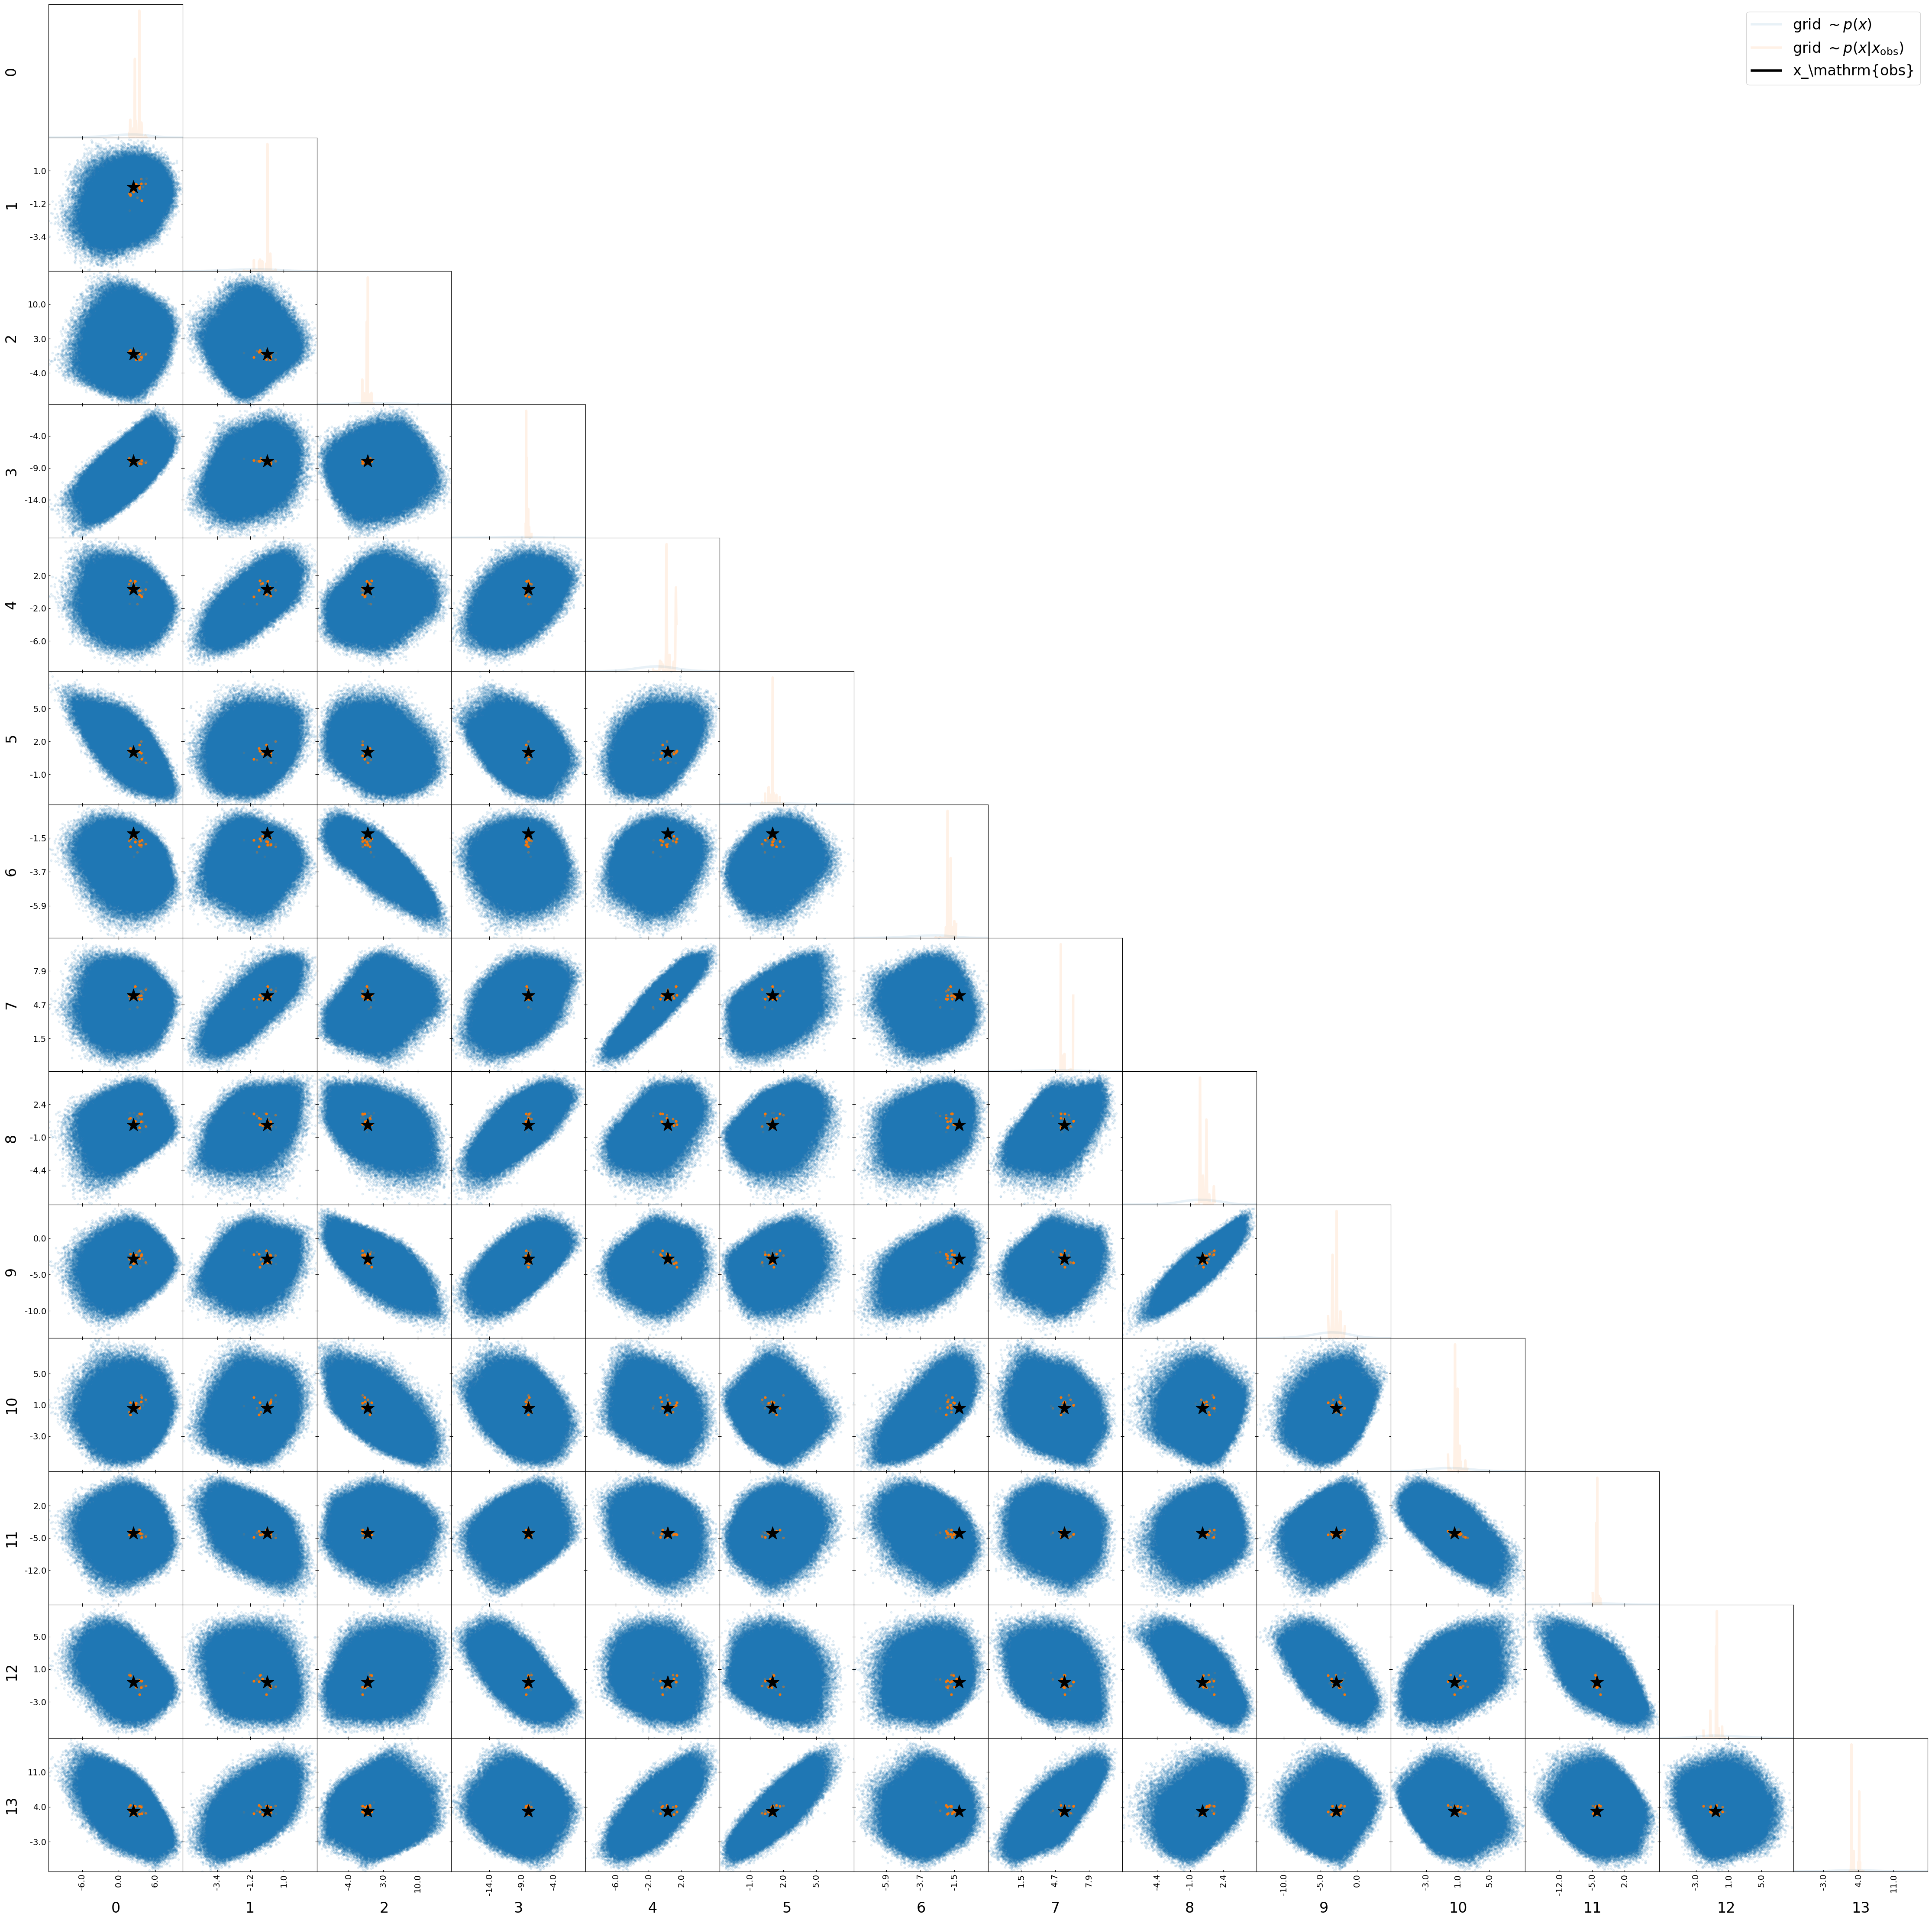

In [13]:
tri = TriangleChain()
tri.scatter(
    grid_preds, 
    scatter_kwargs={"s": 10, "marker": "o"},
    color="tab:blue",
    alpha=0.1,
    label=r"grid $\sim p(x)$",
)
tri.scatter(
    grid_pred_samples, 
    scatter_kwargs={"s": 10, "marker": "o"},
    color="tab:orange",
    label=r"grid $\sim p(x|x_\mathrm{obs})$",
    alpha=0.1,
)
tri.scatter(
    np.array(obs_pred), 
    scatter_kwargs={"s": 500, "marker": "*"},
    color="k",
    label=r"x_\mathrm{obs}",
    show_legend=True,
)

tri.fig.savefig(f"plots/ppc_compression_Buzzard_{i_buzzard}.png", dpi=100)

## $C_\ell$-level

25-06-11 00:01:46 configuratio INF   Loaded the config 
25-06-11 00:01:46 preprocessin INF   Using theta_fwhm = [22.1, 15.1, 11.2, 9.4, 130.2, 88.9, 68.1, 57.0] from the dlss config 
25-06-11 00:01:46 preprocessin INF   Using white_noise_sigma = [0.0010012, 0.0013444, 0.0016358, 0.0017096, 0.85135, 0.34375, 0.25989, 0.24127] from the dlss config 
25-06-11 00:01:46 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-06-11 00:01:46 preprocessin INF   Using l_mins = [0. 0. 0. 0. 0. 0. 0. 0.] by default (no smoothing) 
25-06-11 00:01:46 preprocessin INF   Using n_bins = 33 from the msfm config 
25-06-11 00:01:46 preprocessin INF   Loading the pre-binned Cls 
25-06-11 00:01:46 input_output INF   Loading summaries from /pscratch/sd/a/athomsen/v11desy3/v14/extended 
25-06-11 00:01:46 input_output INF   Array shapes: 
25-06-11 00:01:46 input_output INF   fiducial/i_example 

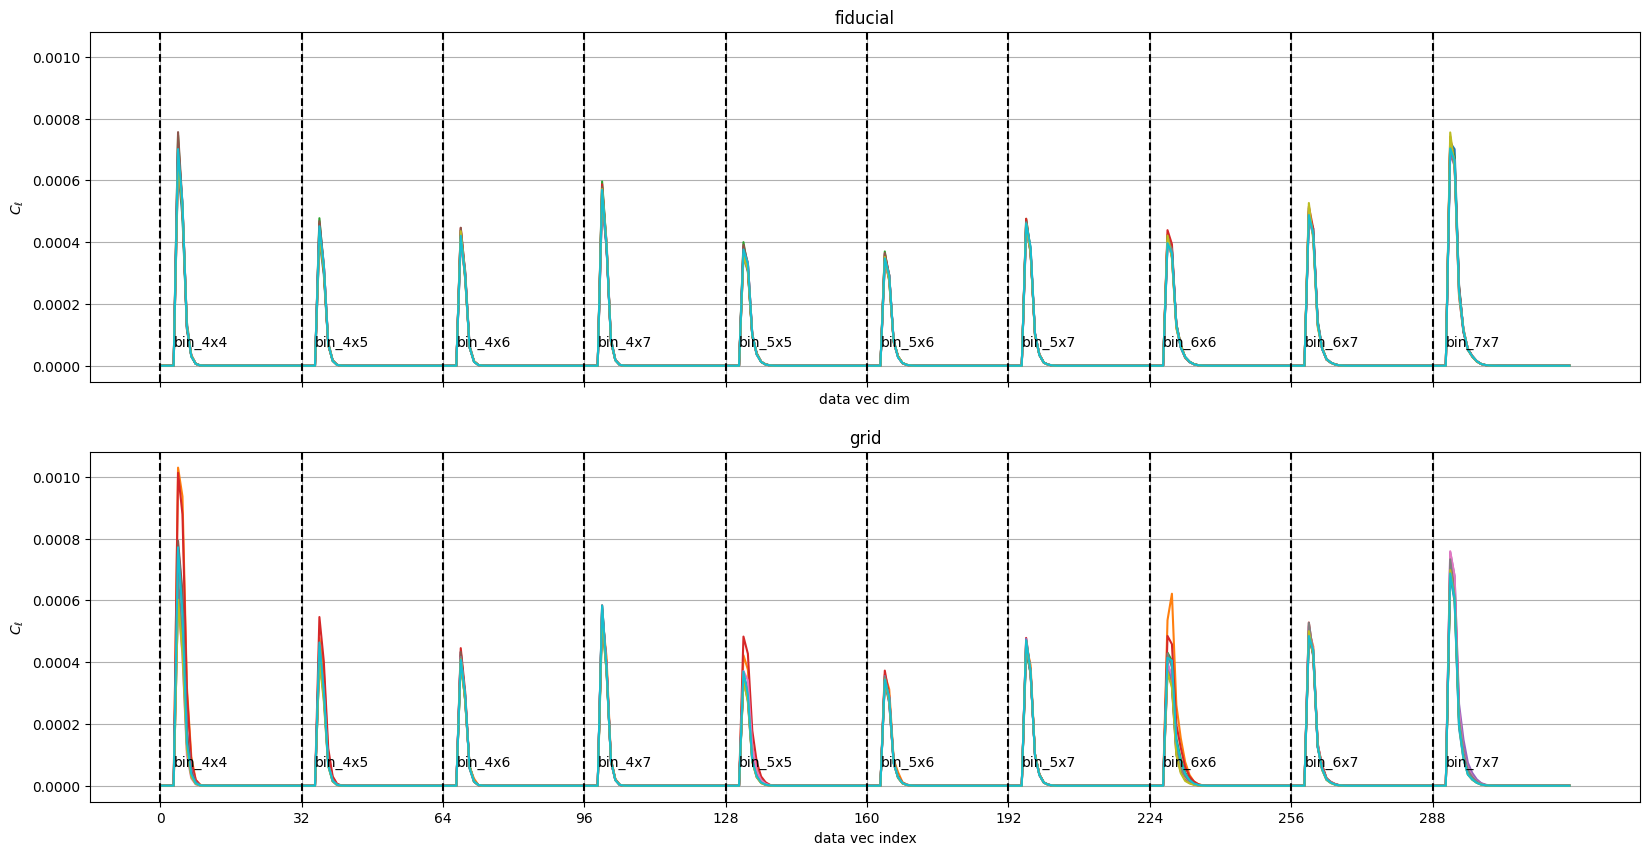

In [14]:
out_dict = preprocessing.get_binned_power_spectra(
    base_dir, 
    # configuration
    msfm_conf=msfm_conf,
    dlss_conf=dlss_conf,
    params=params,
    # selection
    with_lensing=with_lensing,
    with_clustering=with_clustering,
    with_gaussian_noise=True,
    # preprocessing
    apply_log=False,
    standardize=False,
    concat_bin_dim=True,
)

fidu_cls, grid_cls, grid_cosmos = out_dict["fidu/cls"], out_dict["grid/cls/test"], out_dict["grid/cosmos/test"]
print("grid_cls.shape", grid_cls.shape)
print("fidu_cls.shape", fidu_cls.shape)

In [15]:
bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=with_lensing,
    with_clustering=with_clustering,
)

bins = power_spectra.get_cl_bins(
    msfm_conf["analysis"]["power_spectra"]["l_min"], 
    msfm_conf["analysis"]["power_spectra"]["l_max"], 
    msfm_conf["analysis"]["power_spectra"]["n_bins"]
)
current_bins = bins[4:]

# to get rid of l_min
print(bins)
print(bins[5])

[0.00000000e+00 1.49902344e+00 5.99609375e+00 1.34912109e+01
 2.39843750e+01 3.74755859e+01 5.39648437e+01 7.34521484e+01
 9.59375000e+01 1.21420898e+02 1.49902344e+02 1.81381836e+02
 2.15859375e+02 2.53334961e+02 2.93808594e+02 3.37280273e+02
 3.83750000e+02 4.33217773e+02 4.85683594e+02 5.41147461e+02
 5.99609375e+02 6.61069336e+02 7.25527344e+02 7.92983398e+02
 8.63437500e+02 9.36889648e+02 1.01333984e+03 1.09278809e+03
 1.17523438e+03 1.26067871e+03 1.34912109e+03 1.44056152e+03
 1.53500000e+03]
37.47558593750001


### load Buzzard

In [16]:
def get_obs_cls(lensing_file, clustering_file, nest_in=False):
    # load the mock
    with h5py.File(lensing_file, "r") as f_in:
        gamma1 = []
        gamma2 = []
        for j in range(1,5):
            gamma1.append(f_in[f"metacal/raw_gamma1_bin{j}"])
            gamma2.append(f_in[f"metacal/raw_gamma2_bin{j}"])
        gamma1 = np.stack(gamma1, axis=-1)
        gamma2 = np.stack(gamma2, axis=-1)
        
        wl_map = np.stack([gamma1, gamma2], axis=-1)

    with h5py.File(clustering_file, "r") as f_in:
        gc_map = []
        for i in range(1,5):
            gc_map.append(f_in[f"maglim/galaxy_counts_bin{i}"][:])
        gc_map = np.stack(gc_map, axis=-1)

    # forward model
    obs_cls = preprocessing.get_preprocessed_cl_observation(
        wl_gamma_map=wl_map,
        gc_count_map=gc_map,
        # configuration
        msfm_conf=msfm_conf,
        dlss_conf=dlss_conf,
        base_dir=base_dir,
        nest_in=False,
        make_plot=False,
        # selection
        with_lensing=with_lensing,
        with_clustering=with_clustering,
        with_cross_z=True,
        # additional preprocessing
        apply_log=False,
        standardize=False,
    )

    return np.squeeze(obs_cls)


In [17]:
buzzard_cls = []
I = [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
J = [0, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 11, 11]
K = ["a"] + 7 * ["a", "b"]
for i, j, k in [list(zip(I, J, K))[i_buzzard]]:
# for i, j, k in zip(I, J, K):
    lensing_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_buzzard_flock_v14_shear_noise+WL.h5"
    clustering_file = f"/pscratch/sd/j/jbucko/DESY3/mock_observations/lensing/buzzard_flock/{i}/DESY3_mock_observation_Buzzard_{j}_Y3{k}.h5"
    buzzard_cls.append(get_obs_cls(lensing_file, clustering_file))

buzzard_cls = np.squeeze(buzzard_cls)
# obs_cls = np.stack(obs_cls, axis=0)
# obs_cls = np.mean(obs_cls, axis=0)
# obs_cls = np.stack(np.split(obs_cls, grid_cls.shape[-1], axis=-1), axis=-1)

25-06-11 00:02:16 configuratio INF   Loaded the config 
25-06-11 00:02:16 preprocessin INF   Using l_maxs = [ 488.68778281  715.23178808  964.28571429 1148.93617021   82.94930876
  121.4848144   158.59030837  189.47368421] from the dlss config 
25-06-11 00:02:16 preprocessin INF   Using l_mins = [0 0 0 0 0 0 0 0] by default (no smoothing) 
25-06-11 00:02:32 preprocessin INF   Adding white noise to the observation 
25-06-11 00:02:32 preprocessin INF   Using the bin indices [26 27 28 29 30 31 32 33 34 35] 


### plotting

In [40]:
def reshape_full_cls(obs_cls, with_lensing=True, with_clustering=True, concat_bins=True):
    obs_cls_reshaped = np.stack(np.split(obs_cls, 36, axis=-1), axis=-1)

    total_indices, names = cross_statistics.get_cross_bin_indices(
        with_lensing=with_lensing, with_clustering=with_clustering, with_cross_z=True,
    )
    obs_cls_selected = obs_cls_reshaped[:,total_indices]

    if concat_bins:
        obs_cls_selected = np.concatenate([obs_cls_selected[..., i] for i in range(obs_cls_selected.shape[-1])], axis=-1)

    return obs_cls_selected

def reshape_probe_cls(obs_cls):
    return np.stack(np.split(obs_cls, 10, axis=-1), axis=-1)    


In [41]:
with_lensing_plot = False
with_clustering_plot = True
n_z = 4 * with_lensing_plot + 4 * with_clustering_plot

# NOTE this is the important part

# grid_cls_unique_samples, i_unique_samples = np.unique(grid_cls[i_samples], axis=0, return_index=True)
# cosmogrid_cls_reshaped = reshape_probe_cls(grid_cls_unique_samples)
# unique_alphas = alphas[i_unique_samples]

cosmogrid_cls_reshaped = reshape_probe_cls(grid_cls[i_samples])

buzzard_cls_reshaped = reshape_probe_cls(buzzard_cls)

bin_indices, bin_names = cross_statistics.get_cross_bin_indices(
    with_lensing=with_lensing_plot,
    with_clustering=with_clustering_plot,
    with_cross_z=True,
)

bins = power_spectra.get_cl_bins(
    msfm_conf["analysis"]["power_spectra"]["l_min"], 
    msfm_conf["analysis"]["power_spectra"]["l_max"], 
    msfm_conf["analysis"]["power_spectra"]["n_bins"]
)
current_bins = bins[4:]

### samples

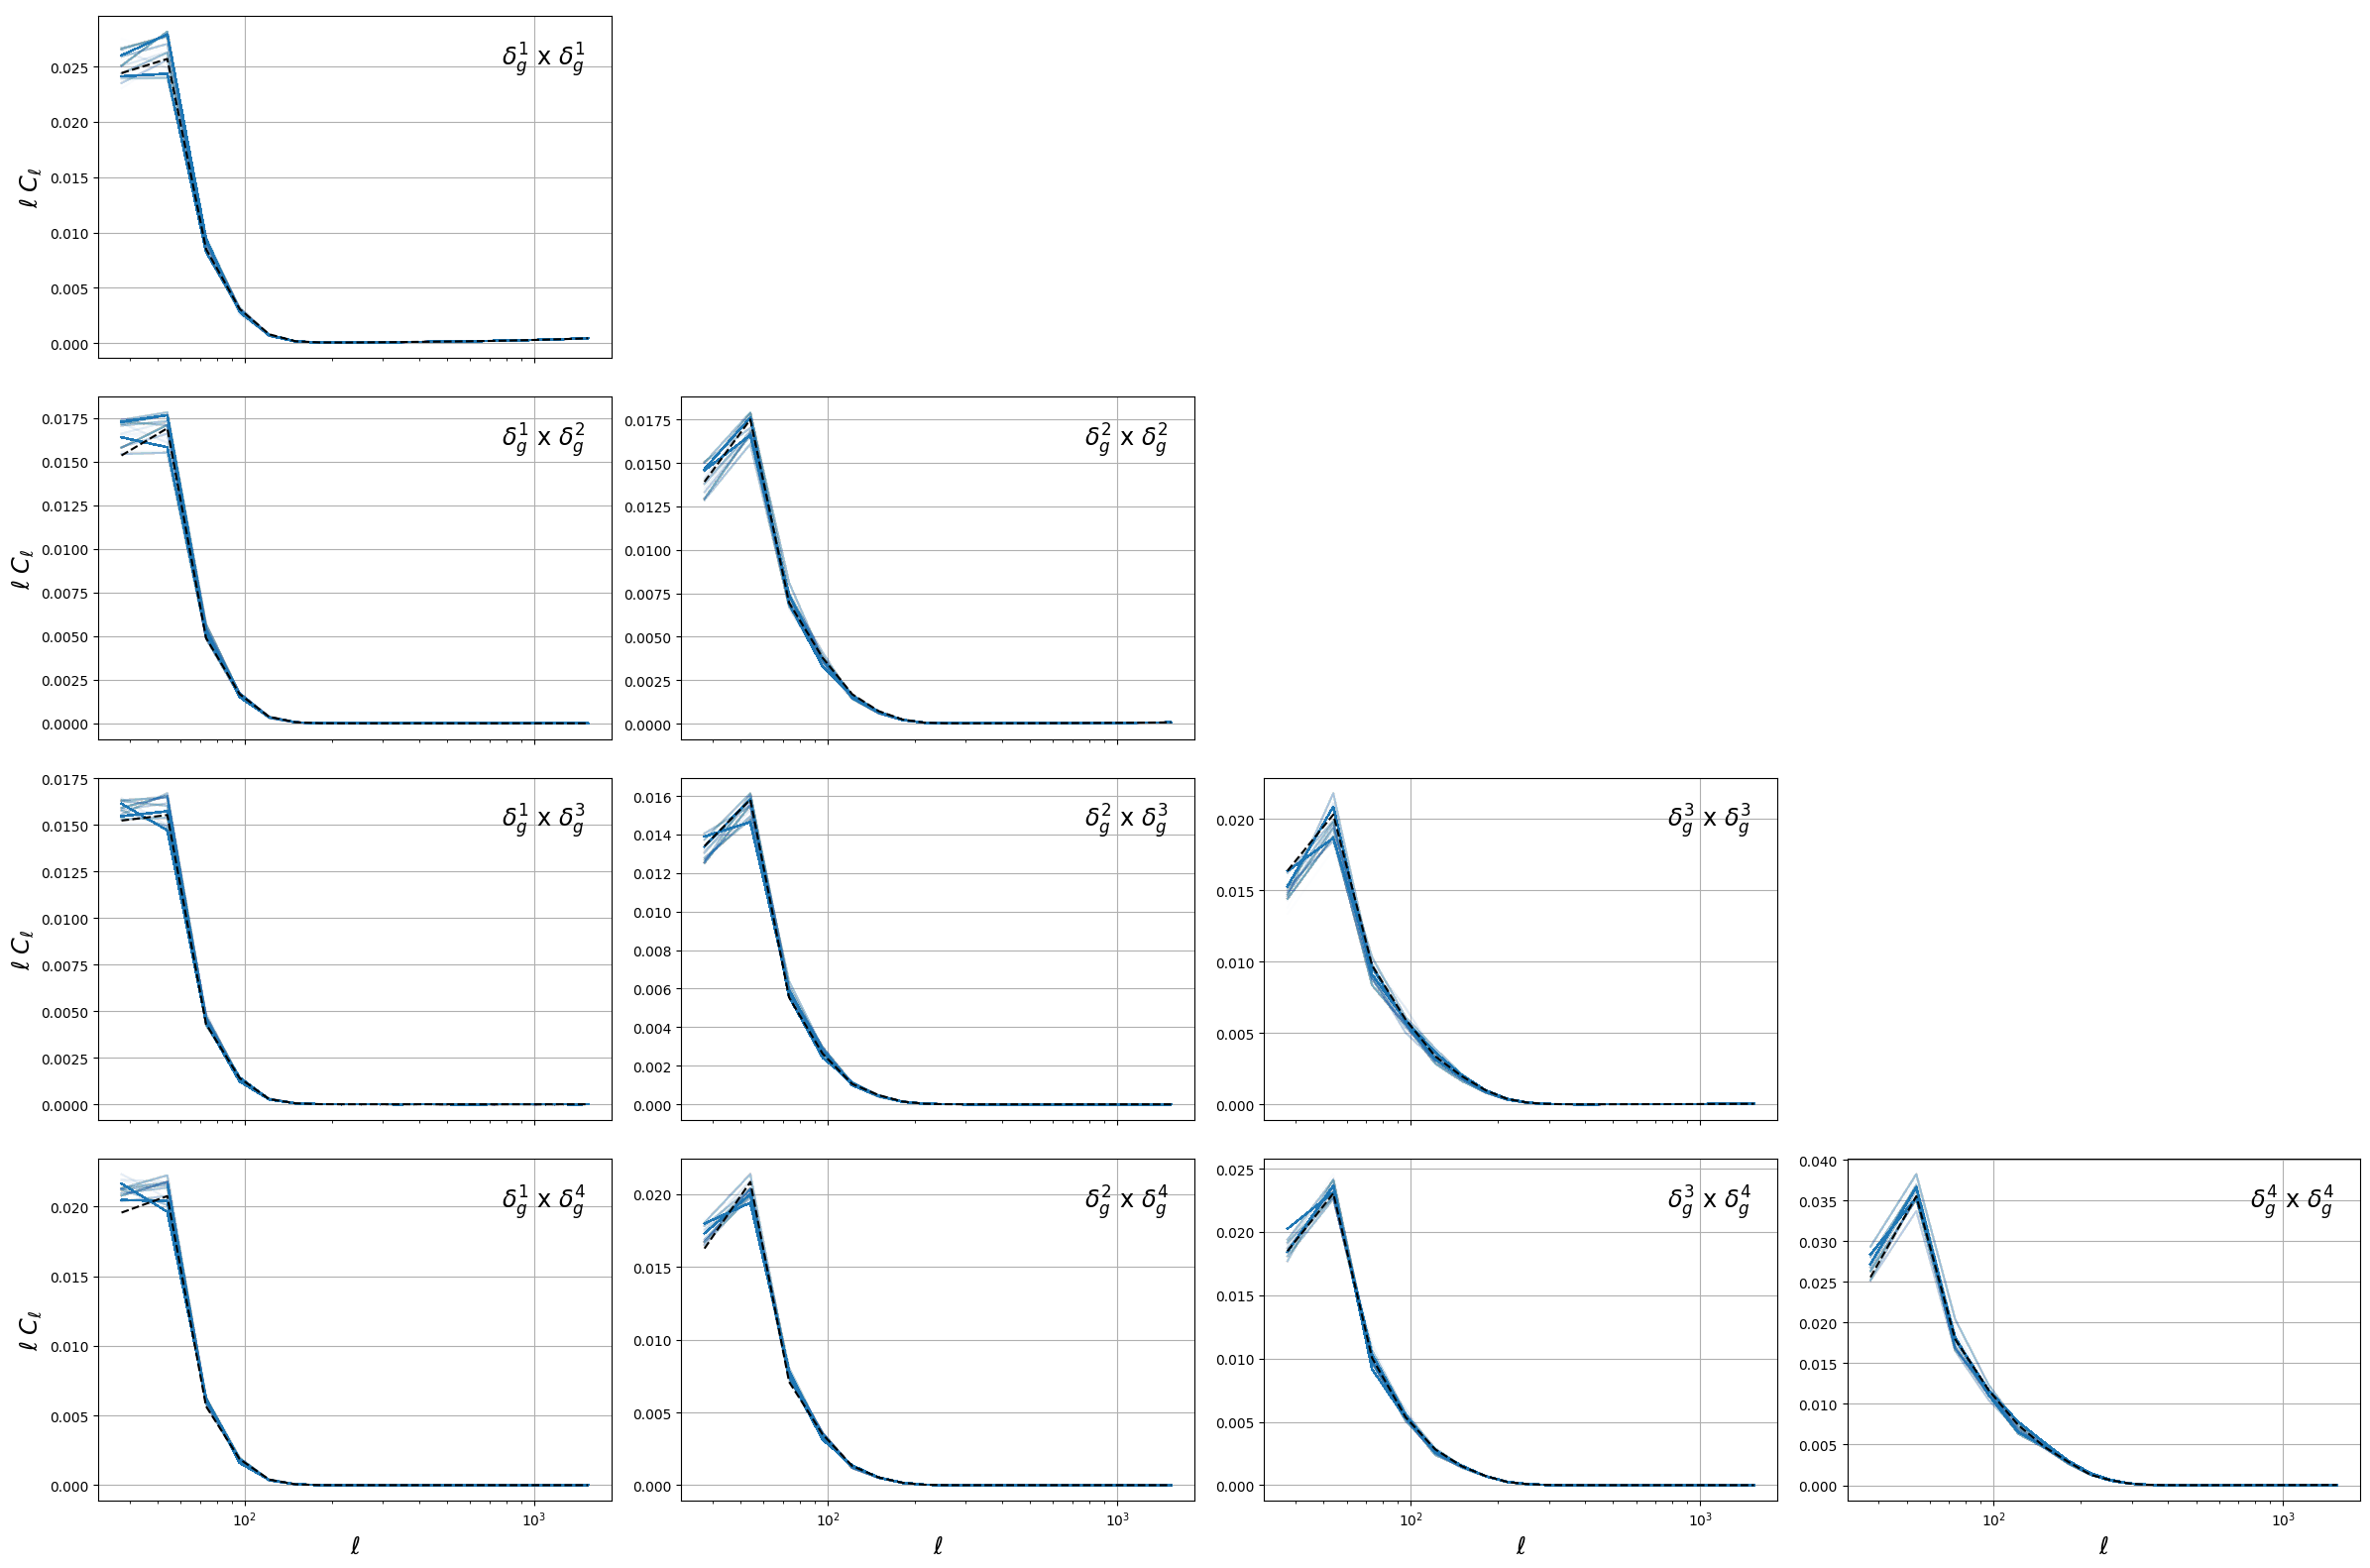

In [42]:
remove_l_min = True
figsize = (24, 16)
# figsize = (12, 8)
fig, ax = plt.subplots(figsize=figsize, nrows=n_z, ncols=n_z, sharex=True, sharey=False)

for k, bin_name in enumerate(bin_names):
    j, i = int(bin_name[-3]), int(bin_name[-1])
    if not with_lensing_plot and with_clustering_plot:
        i -= 4
        j -= 4

    current_bins = bins[1:]
    current_cosmogrid = cosmogrid_cls_reshaped[:, :, k].T
    current_buzzard = buzzard_cls_reshaped[:, k]
    
    if remove_l_min:
        current_bins = bins[5:]
        current_cosmogrid = current_cosmogrid[4:]
        current_buzzard = current_buzzard[4:]
    else:
        current_bins = bins[1:]

    # ax[i,j].plot(current_bins, current_bins[:,np.newaxis] * current_cosmogrid, alpha=1.0) 
    
    # for cls, alpha in zip(current_cosmogrid.T, unique_alphas):
    #     ax[i,j].plot(current_bins, current_bins * cls, alpha=alpha, color="tab:blue") 
    
    for cls in current_cosmogrid.T:
        ax[i,j].plot(current_bins, current_bins * cls, alpha=0.01, color="tab:blue") 
        
    ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--")
    
    # label
    bin_i = rf"\delta_g^{i+1}"
    bin_j = rf"\delta_g^{j+1}"
    bin_label = f"${bin_j}$ x ${bin_i}$"
    ax[i, j].text(
        0.95, 0.93, bin_label,
        transform=ax[i, j].transAxes,
        fontsize='xx-large',
        ha='right', va='top'
    )

    # cosmetics
    ax[i, j].set_box_aspect(2 / 3)
    ax[i, j].grid(True, zorder=0)
    ax[i, j].set(xscale="log")
    if i == n_z - 1:
        ax[i, j].set_xlabel(r"$\ell$", fontsize="xx-large")
    if j == 0:
        ax[i, j].set_ylabel(r"$\ell \; C_\ell$", fontsize="xx-large")

# Turn off upper triangle
for i in range(n_z):
    for j in range(i + 1, n_z):
        ax[i, j].axis('off')

# fig.legend()
fig.tight_layout()

fig.savefig(f"plots/ppc_cls_Buzzard_{i_buzzard}_samples.png", bbox_inches="tight", dpi=100)

### bands

In [24]:
# def weighted_quantile(a, w, q):
#     # a: shape (G,), w normalised to sum to 1, q in [0,1]
#     sorter = np.argsort(a)
#     a, w = a[sorter], w[sorter]
#     cum = np.cumsum(w)
#     return np.interp(q, cum, a)

import numpy as np
from numpy.typing import ArrayLike
from typing import Union, Sequence

def weighted_quantile(a: ArrayLike,
                      w: ArrayLike,
                      q: Union[float, Sequence[float]],
                      axis: int = 0):
    """
    Weighted quantile(s) of `a` along a given axis.

    Parameters
    ----------
    a : array_like
        Data array of shape (..., n_samples, ...).
    w : 1-D array_like
        Non-negative weights for the `n_samples` axis.  Need not be normalised.
    q : float or 1-D sequence of float
        Quantile level(s) in [0, 1].  `0.5` gives the weighted median.
    axis : int, default 0
        Axis of `a` that corresponds to the weight vector.

    Returns
    -------
    quantiles : ndarray
        Array whose first dimension is `len(q)` and whose remaining
        dimensions are those of `a` without the `axis` dimension.
        If `q` is a scalar the first dimension is squeezed away.
    """
    a = np.asarray(a)
    w = np.asarray(w, dtype=float)
    q = np.atleast_1d(q)

    # --- sanity checks ----------------------------------------------------
    if w.ndim != 1:
        raise ValueError("w must be 1-D")
    if a.shape[axis] != w.shape[0]:
        raise ValueError("len(w) must match a.shape[axis]")
    if np.any(q < 0) or np.any(q > 1):
        raise ValueError("q must be in [0, 1]")

    # --- move the weighted axis to the front ------------------------------
    if axis != 0:
        a = np.moveaxis(a, axis, 0)

    # --- normalise weights and broadcast over remaining dims -------------
    w = w / w.sum()
    # shape (n_samples, 1, 1, ...)
    w_b = w[(slice(None),) + (None,)* (a.ndim - 1)]

    # --- sort along the samples axis -------------------------------------
    sorter = np.argsort(a, axis=0)
    a_sorted = np.take_along_axis(a, sorter, axis=0)
    w_sorted = np.take_along_axis(w_b, sorter, axis=0)

    # --- cumulative weight (CDF) -----------------------------------------
    cdf = np.cumsum(w_sorted, axis=0)

    # --- interpolate for every trailing cell -----------------------------
    # output shape: (len(q), ...)  where ... are the trailing dims
    out_shape = (q.size,) + a_sorted.shape[1:]
    quantiles = np.empty(out_shape, dtype=a.dtype)

    # vectorised interpolation: loop only over trailing indices
    it = np.nditer(a_sorted[0], flags=['multi_index'])
    while not it.finished:
        sl = (slice(None),) + it.multi_index      # slice for this column
        quantiles[(slice(None),) + it.multi_index] = np.interp(
            q, cdf[sl], a_sorted[sl]
        )
        it.iternext()

    # --- restore original axis order -------------------------------------
    if axis != 0:
        # bring the quantile axis to the original axis location (+1 because of q-axis)
        quantiles = np.moveaxis(quantiles, 1, axis)

    # squeeze if q was scalar
    if quantiles.shape[0] == 1:
        quantiles = np.squeeze(quantiles, 0)

    return quantiles

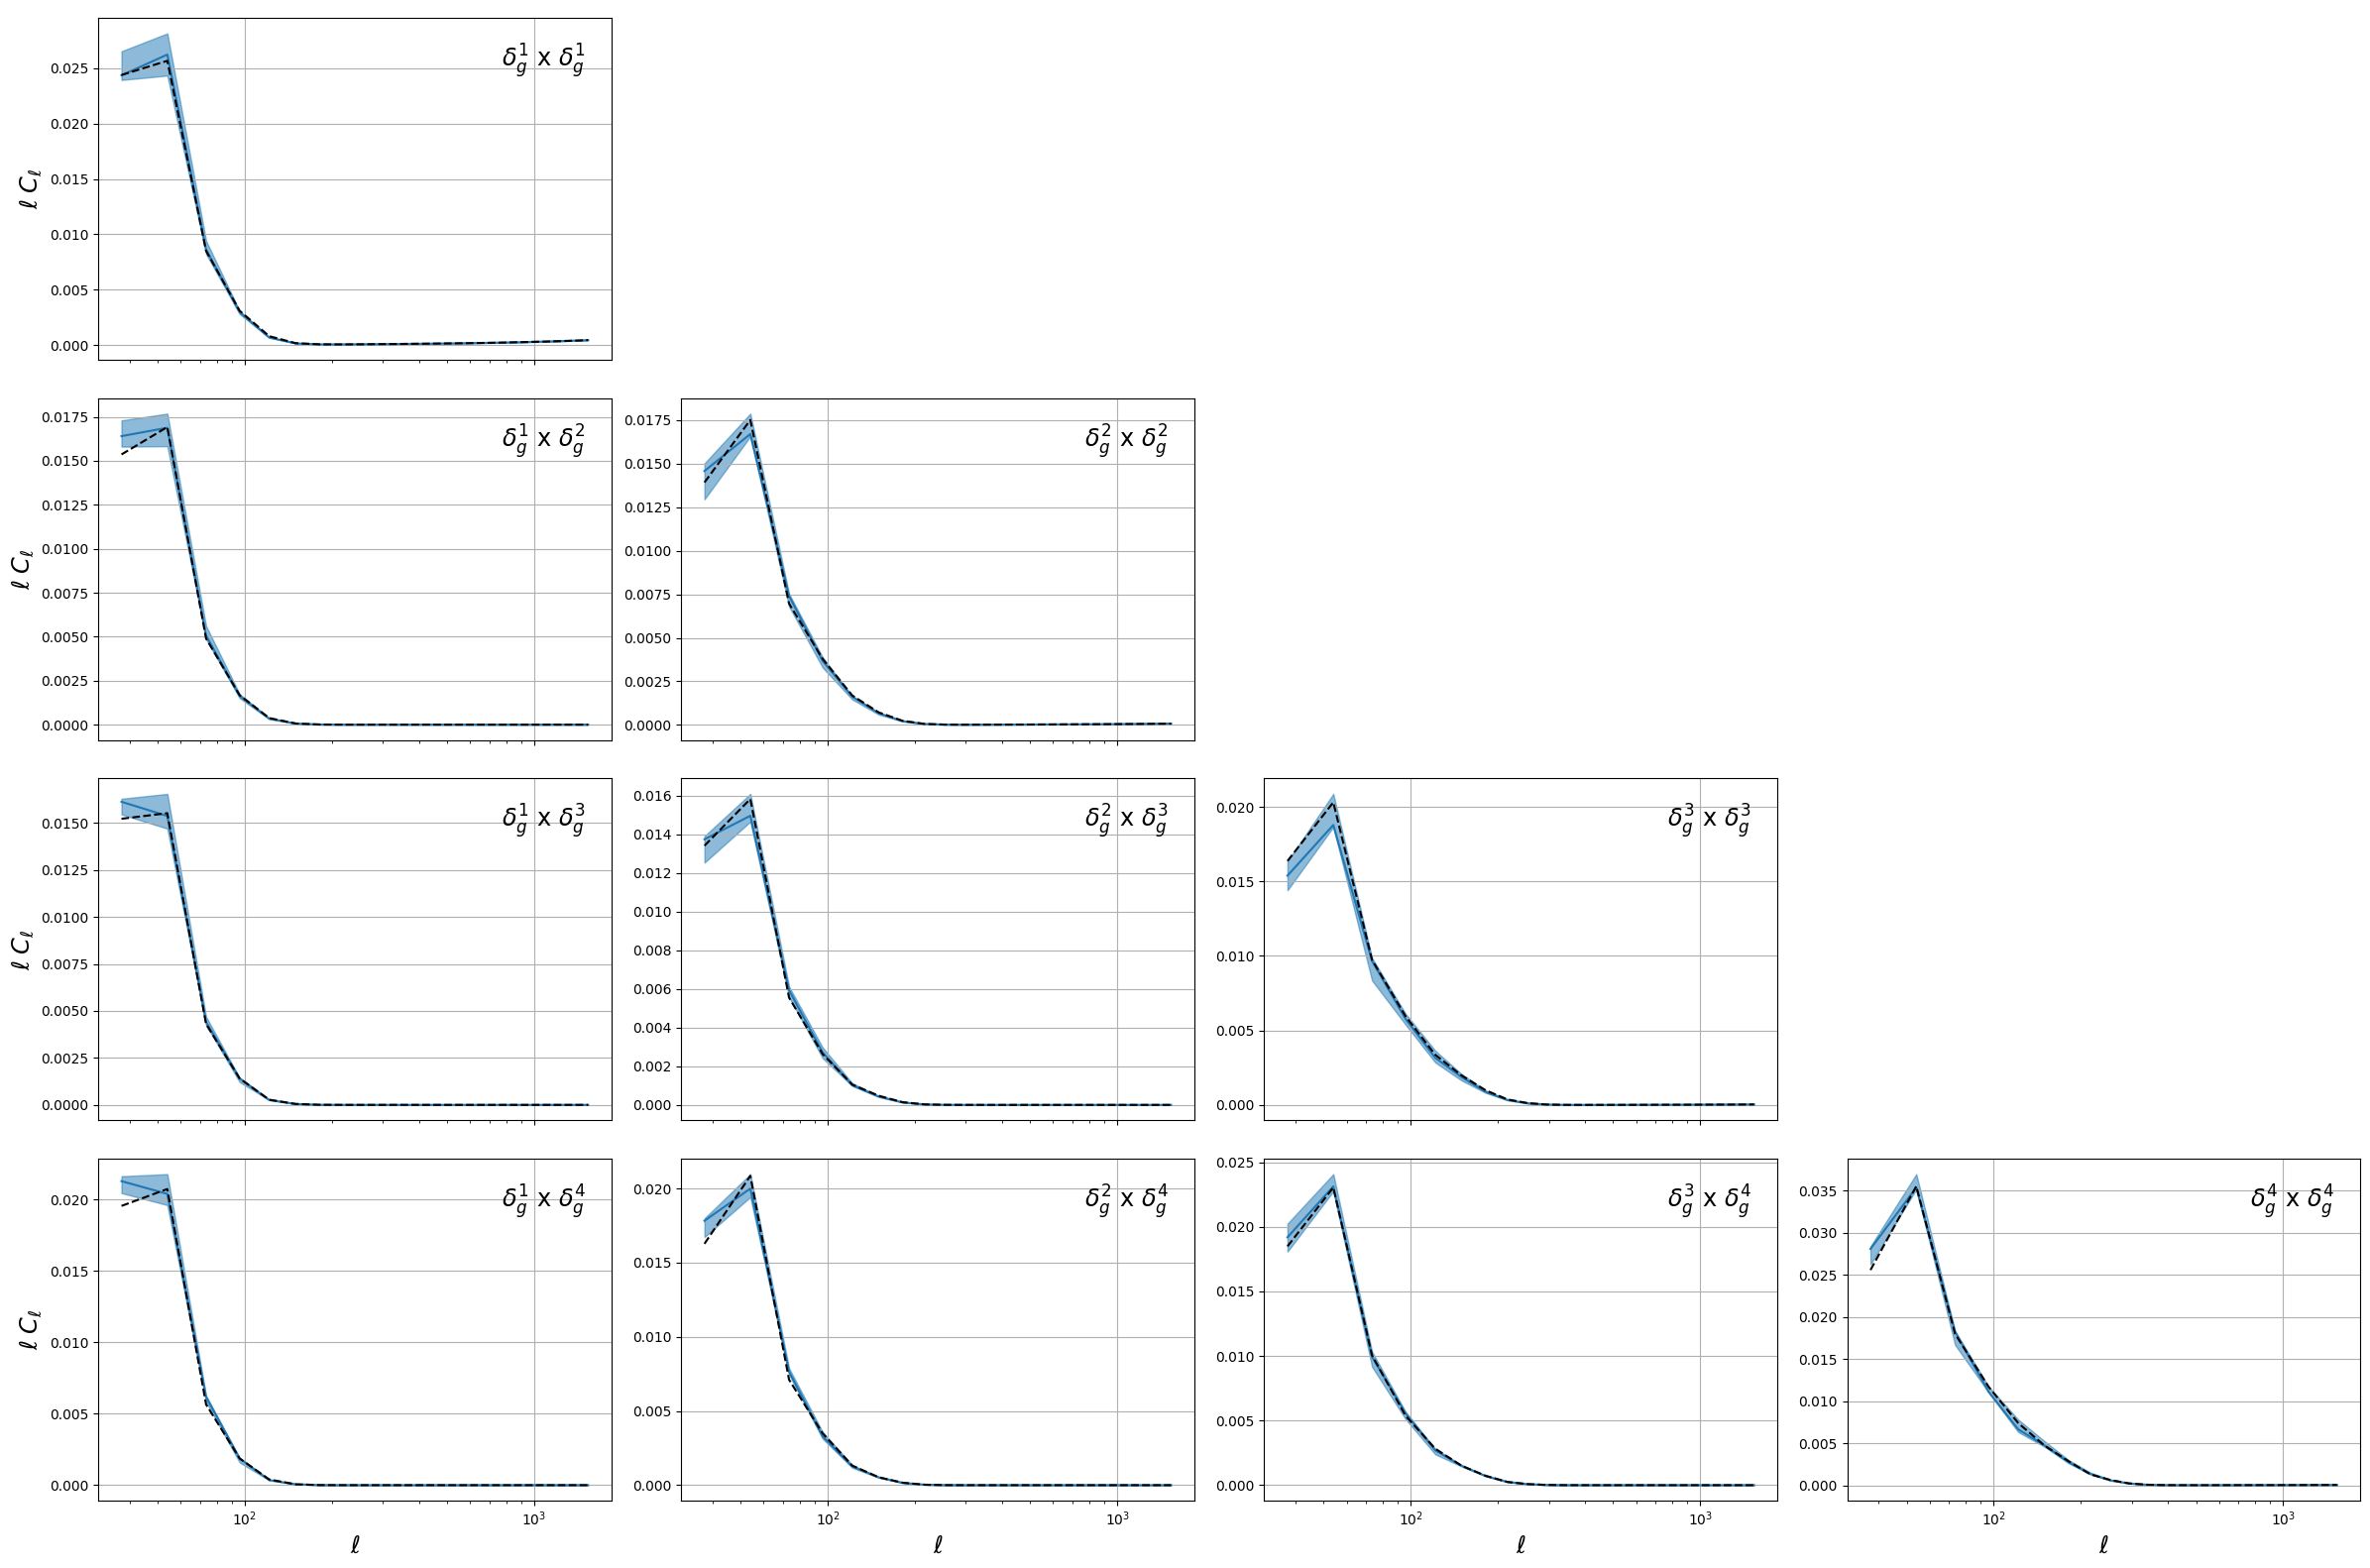

In [39]:
remove_l_min = True
figsize = (24, 16)
# figsize = (12, 8)
fig, ax = plt.subplots(figsize=figsize, nrows=n_z, ncols=n_z, sharex=True, sharey=False)

for k, bin_name in enumerate(bin_names):
    j, i = int(bin_name[-3]), int(bin_name[-1])
    if not with_lensing_plot and with_clustering_plot:
        i -= 4
        j -= 4

    current_bins = bins[1:]
    current_cosmogrid = cosmogrid_cls_reshaped[:, :, k]
    current_buzzard = buzzard_cls_reshaped[:, k]
    
    if remove_l_min:
        current_bins = bins[5:]
        current_cosmogrid = current_cosmogrid[...,4:]
        current_buzzard = current_buzzard[4:]
    else:
        current_bins = bins[1:]


    q05 = weighted_quantile(current_cosmogrid, prob_samples, 0.05, axis=0)
    q50 = weighted_quantile(current_cosmogrid, prob_samples, 0.5, axis=0)
    q95 = weighted_quantile(current_cosmogrid, prob_samples, 0.95, axis=0)
    ax[i,j].plot(current_bins, current_bins * q50, alpha=1.0, color="tab:blue")
    ax[i,j].fill_between(current_bins, current_bins * q05, current_bins * q95, alpha=0.5, color="tab:blue")

    ax[i,j].plot(current_bins, current_bins * current_buzzard, color="k", alpha=1.0, linestyle="--")
    
    # label
    bin_i = rf"\delta_g^{i+1}"
    bin_j = rf"\delta_g^{j+1}"
    bin_label = f"${bin_j}$ x ${bin_i}$"
    ax[i, j].text(
        0.95, 0.93, bin_label,
        transform=ax[i, j].transAxes,
        fontsize='xx-large',
        ha='right', va='top'
    )

    # cosmetics
    ax[i, j].set_box_aspect(2 / 3)
    ax[i, j].grid(True, zorder=0)
    ax[i, j].set(xscale="log")
    if i == n_z - 1:
        ax[i, j].set_xlabel(r"$\ell$", fontsize="xx-large")
    if j == 0:
        ax[i, j].set_ylabel(r"$\ell \; C_\ell$", fontsize="xx-large")

# Turn off upper triangle
for i in range(n_z):
    for j in range(i + 1, n_z):
        ax[i, j].axis('off')

# fig.legend()
fig.tight_layout()

fig.savefig(f"plots/ppc_cls_Buzzard_{i_buzzard}_band.png", bbox_inches="tight", dpi=100)